## Model Saving/Loading Example

This set of examples shows how to load and import template models in order to make setting up and reproducing circuit fits easier.

In [15]:
# Load libraries

import impedance as imp
import impedance.preprocessing as preprocessing
import impedance.circuits as circuits
import impedance.plotting as imp_plot
import impedance.model_io as model_io
import numpy as np
import matplotlib.pyplot as plt


In [20]:
# Load data from the example EIS result

data = np.genfromtxt('data/exampleData.csv', delimiter=',')

frequencies = data[:,0]
Z = data[:,1] + 1j*data[:,2]

# keep only the impedance data in the first quandrant
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)



### Example 1. Importing and Exporting Models

Call the `model_io.model_export` function to export the model to a human readable JSON file. The following code generates a test circuit and export it as a template. Here we are using an unfitted model as a template.


In [21]:
test_circuit = circuits.CustomCircuit(initial_guess=[.01, .005, .1, .005, .1, .001, 200],
                              circuit='R0-p(R1,C1)-p(R2,C2)-W1') 

print(test_circuit)

model_io.model_export(test_circuit, 'template_model.json')


Circuit string: R0-p(R1,C1)-p(R2,C2)-W1
Fit: False

Initial guesses:
     R0 = 1.00e-02 [Ohm]
     R1 = 5.00e-03 [Ohm]
     C1 = 1.00e-01 [F]
     R2 = 5.00e-03 [Ohm]
     C2 = 1.00e-01 [F]
   W1_0 = 1.00e-03 [Ohm]
   W1_1 = 2.00e+02 [sec]



Call the `model_io.model_import` function to import the model back as a template.

In [22]:
loaded_template = model_io.model_import('template_model.json')

print("Loaded Template")
print(loaded_template)

Loaded Template

Circuit string: R0-p(R1,C1)-p(R2,C2)-W1
Fit: False

Initial guesses:
     R0 = 1.00e-02 [Ohm]
     R1 = 5.00e-03 [Ohm]
     C1 = 1.00e-01 [F]
     R2 = 5.00e-03 [Ohm]
     C2 = 1.00e-01 [F]
   W1_0 = 1.00e-03 [Ohm]
   W1_1 = 2.00e+02 [sec]



### Example 2. Using imported template model to fit data

After the model has been imported as a template, it can be used as a starting point to fit data. This saves on needing to configure the initial parameters each time a fit is performed and to persist starting conditions across several fitting sessions.

Simulating circuit based on initial parameters


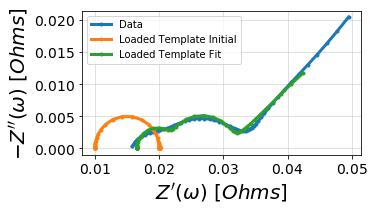


Circuit string: R0-p(R1,C1)-p(R2,C2)-W1
Fit: True

Initial guesses:
     R0 = 1.00e-02 [Ohm]
     R1 = 5.00e-03 [Ohm]
     C1 = 1.00e-01 [F]
     R2 = 5.00e-03 [Ohm]
     C2 = 1.00e-01 [F]
   W1_0 = 1.00e-03 [Ohm]
   W1_1 = 2.00e+02 [sec]

Fit parameters:
     R0 = 1.65e-02  (+/- 1.54e-04) [Ohm]
     R1 = 5.31e-03  (+/- 2.06e-04) [Ohm]
     C1 = 2.32e-01  (+/- 1.90e-02) [F]
     R2 = 8.77e-03  (+/- 1.89e-04) [Ohm]
     C2 = 3.28e+00  (+/- 1.85e-01) [F]
   W1_0 = 6.37e-02  (+/- 2.03e-03) [Ohm]
   W1_1 = 2.37e+02  (+/- 1.72e+01) [sec]



In [23]:
fig, ax = plt.subplots(figsize=(5,5))
f_pred = np.logspace(5,-2)
loaded_template.fit(frequencies, Z)

imported_circuit_init = loaded_template.predict(f_pred, use_initial = True)
imported_circuit_fit = loaded_template.predict(f_pred)

imp_plot.plot_nyquist(ax, frequencies, Z)
imp_plot.plot_nyquist(ax, f_pred, imported_circuit_init)
imp_plot.plot_nyquist(ax, f_pred, imported_circuit_fit)

ax.legend(['Data', 'Loaded Template Initial', 'Loaded Template Fit'])

plt.show()
print(loaded_template)

### Example 3. Using fitted data as a starting point for new fits

Consider the case where a successful fit has been performed and a new set of EIS data is obtained which is similar to the first spectrum. It is useful to use the successfully fitted parameters as a starting point for subsequent fits.

In [24]:
# Export the fitted model as a template

model_io.model_export(loaded_template, 'fitted_template.json')

Using the exported model's fitted parameters, generate a new circuit using the fitted parameters as initial guesses by suppling the `fitted_as_initial` parameter as `True`.

In [25]:
fitted_template = model_io.model_import('fitted_template.json', fitted_as_initial=True)
print(fitted_template)


Circuit string: R0-p(R1,C1)-p(R2,C2)-W1
Fit: False

Initial guesses:
     R0 = 1.65e-02 [Ohm]
     R1 = 5.31e-03 [Ohm]
     C1 = 2.32e-01 [F]
     R2 = 8.77e-03 [Ohm]
     C2 = 3.28e+00 [F]
   W1_0 = 6.37e-02 [Ohm]
   W1_1 = 2.37e+02 [sec]



Z2 is a similar impedance spectra that we can fit using the previous fitted parameters as starting points. It has been shifted by 5 mOhm in the real axis and the data has been scaled by 1.5x.

In [30]:
frequencies = data[:,0]
Z2 = (0.005+data[:,1])*1.5 + 1.5j*data[:,2]
frequencies, Z2 = preprocessing.ignoreBelowX(frequencies, Z2) 

Simulating circuit based on initial parameters


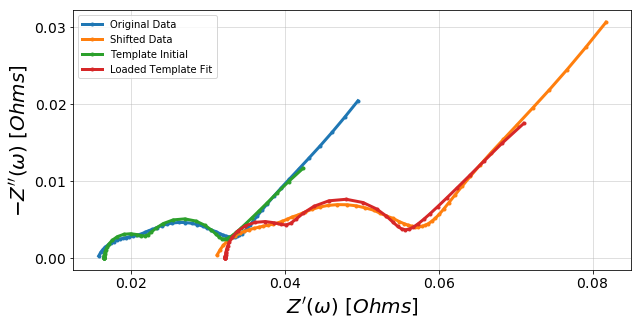

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
f_pred = np.logspace(5,-2)
fitted_template.fit(frequencies, Z2)

imported_circuit_init = fitted_template.predict(f_pred, use_initial = True)
imported_circuit_fit = fitted_template.predict(f_pred)

imp_plot.plot_nyquist(ax, frequencies, Z)
imp_plot.plot_nyquist(ax, frequencies, Z2)
imp_plot.plot_nyquist(ax, f_pred, imported_circuit_init)
imp_plot.plot_nyquist(ax, f_pred, imported_circuit_fit)

ax.legend(['Original Data', 'Shifted Data', 'Template Initial', 'Loaded Template Fit'])

plt.show()

print(fitted_template)